In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# classifiers / models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# other
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE


import warnings
warnings.filterwarnings("ignore") # probably not good practice to ignore *all* warnings, but gets the job done for now

In [2]:
data = pd.read_csv("../data/matches_scorecard_player_details.csv")
print("Shape:",data.shape)
#print(list(data.columns))

Shape: (4010, 277)


## Predicting Match Winner

In [3]:
# Removing non-predictive columns
urls = [c for c in data.columns if c[-3:]=="url"]
names = [c for c in data.columns if c[-4:]=="name"]
styles = [c for c in data.columns if c[-5:]=="style"]
ages = [c for c in data.columns if c[-3:]=="age"]
data_subset = data.drop(['team1', 'team2','scorecard','margin','attendance', 'ground','match_date', 'world_cup']+urls+names+styles+ages, axis=1)
print("Shape:", data_subset.shape)

Shape: (4010, 123)


In [4]:
def f(row):
    "Turns match winner into Team 1 or Team 2 or Tied"
    if row['team_1'] == row['winner']:
        val = 'team_1'
    elif row['team_2'] == row['winner']:
        val = 'team_2'
    else:
        val = 'tied'
    return val

y = data_subset.apply(f, axis=1)
X = data_subset.drop(['team_1', 'team_2', 'winner'], axis=1)
print('X and y shapes:', X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('Train and Test sets shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X and y shapes: (4010, 120) (4010,)
Train and Test sets shapes: (3007, 120) (1003, 120) (3007,) (1003,)


In [5]:
scaler = StandardScaler()
scaler_model = scaler.fit(X_train)
X_train = scaler_model.transform(X_train)
X_test = scaler_model.transform(X_test)
X_full = scaler_model.transform(X)

### A Quick Look at the Baseline

In [6]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print('DecisionTreeClassifier')
print('  Train accuracy:', dtc.score(X_train,y_train))
print('  Test accuracy:', dtc.score(X_test,y_test))

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print('RandomForestClassifier')
print('  Train accuracy:', rfc.score(X_train,y_train))
print('  Test accuracy:', rfc.score(X_test,y_test))

mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)
print('MLPClassifier')
print('  Train accuracy:', mlpc.score(X_train,y_train))
print('  Test accuracy:', mlpc.score(X_test,y_test))

svc = SVC()
svc.fit(X_train, y_train)
print('SVC')
print('  Train accuracy:', svc.score(X_train,y_train))
print('  Test accuracy:', svc.score(X_test,y_test))

DecisionTreeClassifier
  Train accuracy: 0.9996674426338543
  Test accuracy: 0.5712861415752741
RandomForestClassifier
  Train accuracy: 0.9860325906218823
  Test accuracy: 0.6071784646061814
MLPClassifier
  Train accuracy: 0.9996674426338543
  Test accuracy: 0.6281156530408774
SVC
  Train accuracy: 0.8377120053209178
  Test accuracy: 0.6679960119641076


### Tuning Hyperparameters for the _Better_ Models

In [7]:
# Random Forest
param_grid = {'n_estimators' : [10, 50, 100], 
              'criterion' : ['gini', 'entropy'], 
              'max_depth' : [10, 50, 100],
              'min_samples_split': [2, 5, 20]}

rfc_gridsearch = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid)
print("Number of configurations:", np.prod(list(map(len, param_grid.values()))))

rfc_gridsearch.fit(X_train, y_train)
print('Best Parameters', rfc_gridsearch.best_params_)
print("Training Accuracy:",rfc_gridsearch.score(X_train, y_train))
print("Test Accuracy    :",rfc_gridsearch.score(X_test, y_test))

Number of configurations: 54
Best Parameters {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}
Training Accuracy: 0.9281676089125375
Test Accuracy    : 0.6630109670987039


In [8]:
# Feed forward Neural Network (MLP Classifier)
param_grid = {'hidden_layer_sizes' : [(50,), (10,), (10,10)], 
              'learning_rate_init' : [1e-4, 1e-3, 1e-2], 
              'alpha' : [1e-5, 1e-4, 1e-3], 
              'activation' : ['relu', 'tanh']}

mlp_gridsearch = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid)
print("Number of configurations:", np.prod(list(map(len, param_grid.values()))))

mlp_gridsearch.fit(X_train, y_train)
print('Best Parameters', mlp_gridsearch.best_params_)
print("Training Accuracy:",mlp_gridsearch.score(X_train, y_train))
print("Test Accuracy    :",mlp_gridsearch.score(X_test, y_test))

Number of configurations: 54
Best Parameters {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.0001}
Training Accuracy: 0.7273029597605587
Test Accuracy    : 0.6520438683948155


In [9]:
# SVC
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10], 
              'kernel' : ['rbf', 'poly', 'sigmoid', 'linear'], 
              'gamma' : [0.001, 0.01, 0.1, 1]}

svc_gridsearch = GridSearchCV(estimator=SVC(), param_grid=param_grid)
print("Number of configurations:", np.prod(list(map(len, param_grid.values()))))

svc_gridsearch.fit(X_train, y_train)
print('Best Parameters', svc_gridsearch.best_params_)
print("Training Accuracy:",svc_gridsearch.score(X_train, y_train))
print("Test Accuracy    :",svc_gridsearch.score(X_test, y_test))

Number of configurations: 80
Best Parameters {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
Training Accuracy: 0.6923844363152644
Test Accuracy    : 0.6630109670987039


### A Deeper Look at the Results

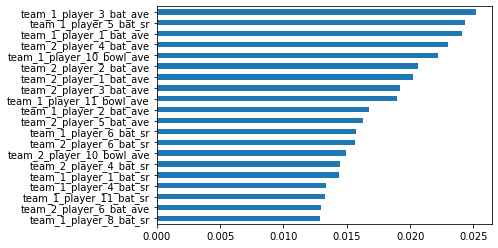

In [10]:
features = X.columns
importances = rfc_gridsearch.best_estimator_.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()

It is amazing how the strongest predictors sync with intuition very nicely!